# Скачивание данных

In [330]:
import vk
import time
import requests
import json
from tqdm import tqdm_notebook
import networkx as nx
from scipy.sparse import coo_matrix
from sklearn.cluster import SpectralClustering
import matplotlib.pyplot as plt
import numpy as np
from networkx.algorithms.community.quality import modularity
token='86e753f69a67a9bdd36e5dd752e65aa920310be142a4ef75874aaa8f969405060738c15828eb39d3705a3'
session = vk.Session(access_token = token)
api = vk.API(session)
group = '160008281'

In [290]:
group_mem = api.groups.getMembers(group_id=group,sort='id_asc', v="5.89")
group_mem_num=group_mem['count']
group_mem_ids=group_mem['items']
not_closed_ids=[]

In [291]:
all_friends=dict()
group_members_data=dict()
for i in tqdm_notebook(group_mem_ids):
    try:
       temp_user_info=api.users.get(user_id=i,fields='is_closed, sex, bdate, city, country, universities, schools',v="5.89")
       if 'is_closed' in temp_user_info[0]:
          if temp_user_info[0]['is_closed']==False:
              group_members_data[i]=temp_user_info[0]
              all_friends[i]=api.friends.get(user_id=i,fields='sex, bdate, city, country, universities, schools',v="5.89")['items']
              not_closed_ids.append(i)
       time.sleep(1)
    except requests.exceptions.ReadTimeout:
       print("Переподключение к серверам ВК")
       time.sleep(2)
       temp_user_info=api.users.get(user_id=i,fields='is_closed, sex, bdate, city, country, universities, schools',v="5.89")
       if 'is_closed' in temp_user_info[0]:
          if temp_user_info[0]['is_closed']==False:
             group_members_data[i]=temp_user_info[0]
             all_friends[i]=api.friends.get(user_id=i,fields='sex, bdate, city, country, universities, schools',v="5.89")['items']
             not_closed_ids.append(i)
       time.sleep(1)

<ipython-input-291-6cfd2d803035>:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm_notebook(group_mem_ids):


In [292]:
friendmem_op=[]#друзья друзей, которые не члены группы и чьи профили открыты
friendmem_cl=[]
for key in all_friends:
    for friend in all_friends[key]:
        if 'is_closed' in friend: #может быть удаленный пользователь без этого поля
           if friend['is_closed']==False:
              if (friend['id'] not in not_closed_ids) and (friend['id'] not in friendmem_op):
                 friendmem_op.append(friend['id'])
           else:
              friendmem_cl.append(friend['id'])

In [293]:
def break_list(l): #разбиение списка на списки по 100 элем и обьединение этих списков в список списков
    length_100=len(l)//100
    res=[]
    coun=0
    rem=len(l)-100*length_100
    for i in range (0,length_100):
        res.append([])
        for j in range(0,100):
            res[i].append(l[coun])
            coun=coun+1
        print(res)
    if rem!=0:
       res.append([])
       for j in range(0,rem):
           res[length_100].append(l[coun])
           coun=coun+1
    return res

In [294]:
frbrf=dict()
for fr in friendmem_op:
    frbrf[fr]=[]
broke=break_list(not_closed_ids)
for key in tqdm_notebook(frbrf):
    for i in range(0,len(broke)):
        try:
           beta=api.friends.getMutual(source_uid=key, target_uids=broke[i],v='5.74')
           frbrf[key]=beta
           time.sleep(0.6)
        except requests.exceptions.ReadTimeout:
           print("Переподключение к серверам ВК")
           time.sleep(3)
           beta=api.friends.getMutual(source_uid=key, target_uids=broke[i],v='5.74')
           frbrf[key]=beta
           time.sleep(0.6)
frbrf_cl=dict()
for key in frbrf:
    frbrf_cl[key]=[]
    for user in frbrf[key]:
        if user['common_friends']!=[]:
            for elem in user['common_friends']:
                frbrf_cl[key].append(elem)
central_relat=dict()
for key in all_friends:
    central_relat[key]=[]
    for i in all_friends[key]:
        central_relat[key].append(i['id'])

<ipython-input-294-0390834a0b96>:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for key in tqdm_notebook(frbrf):


Переподключение к серверам ВК
Переподключение к серверам ВК
Переподключение к серверам ВК
Переподключение к серверам ВК
Переподключение к серверам ВК
Переподключение к серверам ВК



In [295]:
#with open('group_members_data.json', 'w', encoding='utf-8') as fh: #открываем файл на запись
#    fh.write(json.dumps(group_members_data, ensure_ascii=False))
#with open('all_friends.json', 'w', encoding='utf-8') as fh: #открываем файл на запись
#    fh.write(json.dumps(all_friends, ensure_ascii=False))
#with open('frbfr_cl.json', 'w', encoding='utf-8') as fh: #открываем файл на запись
#    fh.write(json.dumps(frbrf_cl, ensure_ascii=False))
#with open('central_relat.json', 'w', encoding='utf-8') as fh: #открываем файл на запись
#    fh.write(json.dumps(central_relat, ensure_ascii=False))

# Предобработка данных

In [ ]:
# Uncomment if you are using colab
# !mkdir ./data
# !mkdir ./data/1504653

#!wget https://github.com/Ivan-mech99/Graphs/blob/main/all_friends.json
#!wget https://github.com/Ivan-mech99/Graphs/blob/main/central_relat.json
#!wget https://github.com/Ivan-mech99/Graphs/blob/main/frbfr_cl.json
#!wget https://github.com/Ivan-mech99/Graphs/blob/main/group_members_data.json

In [331]:
with open('group_members_data.json', 'r', encoding='utf-8') as fh: #открываем файл на чтение
    group_members_data = json.load(fh)
with open('all_friends.json', 'r', encoding='utf-8') as fh: #открываем файл на чтение
    all_friends = json.load(fh)
with open('frbfr_cl.json', 'r', encoding='utf-8') as fh: #открываем файл на чтение
    frbfr_cl = json.load(fh)
with open('central_relat.json', 'r', encoding='utf-8') as fh: #открываем файл на чтение
    central_relat = json.load(fh)

In [332]:
not_closed_ids=[]
for key in group_members_data:
    not_closed_ids.append(key)

In [333]:
def remomake(group_members_data,key,name1,name2,namef):
   if name1 in group_members_data[key]:
      if name2 in group_members_data[key][name1]:
         if group_members_data[key][name1][name2]!='':
            group_members_data[key][namef]=group_members_data[key][name1][name2]
   group_members_data[key].pop(name1,None)
def remomake1(group_members_data,key,name1,name2,namef):
   if name1 in group_members_data[key]:
      if len(group_members_data[key][name1])!=0:
         if name2 in group_members_data[key][name1][0]:
            if group_members_data[key][name1][0][name2]!='':
               group_members_data[key][namef]=group_members_data[key][name1][0][name2]
   group_members_data[key].pop(name1,None)
def remomake2(group_members_data,key,name1,name2,namef):
   if name1 in group_members_data[key]:
      if len(group_members_data[key][name1])!=0:
         if name2 in group_members_data[key][name1][0]:
            if group_members_data[key][name1][0][name2]!='':
               group_members_data[key][namef]=group_members_data[key][name1][0][name2]

In [334]:
#Нужны поля: country_name:
#            city_name
#            age
#            university name
#            faculty name
#            school name
def work_on_data(group_members_data):
   for key in group_members_data:
      #print(group_members_data[key])
      group_members_data[key]['country_name']='-1'
      group_members_data[key]['city_name']='-1'
      #group_members_data[key]['age']='-1'
      group_members_data[key]['university_name']='-1'
      group_members_data[key]['faculty_name']='-1'
      group_members_data[key]['school_name']='-1'
def second_work(group_members_data):
   for key in group_members_data:
      remomake(group_members_data,key,'city','title','city_name')
      remomake(group_members_data,key,'country','title','country_name')
      remomake2(group_members_data,key,'universities','faculty_name','faculty_name')
      remomake1(group_members_data,key,'universities','name','university_name')
      remomake1(group_members_data,key,'schools','name','school_name')
      if 'bdate' in  group_members_data[key]:
         text=group_members_data[key]['bdate']
         res=text.split(".")
         if(len(res)==3 and res[2]!=''):
            group_members_data[key]['age']=2020-int(res[2])
         group_members_data.pop('bdate',-1)
def simple_func(all_friends):
   for key in all_friends:
      for elem in all_friends[key]:
         elem['country_name']='-1'
         elem['city_name']='-1'
         #elem['age']='-1'
         elem['university_name']='-1'
         elem['faculty_name']='-1'
         elem['school_name']='-1'
def simplier(all_friends,name1,name2,namef):
   for key in all_friends:
      for elem in all_friends[key]:
         if name1 in elem:
            if name2 in elem[name1]:
               if elem[name1][name2]!='':
                  elem[namef]=elem[name1][name2]
         elem.pop(name1,None)
def more_simply(all_friends,name1,name2,namef):
   for key in all_friends:
      for elem in all_friends[key]:
         if name1 in elem:
            if len(elem[name1])!=0:
               if name2 in elem[name1][0]:
                  if elem[name1][0][name2]!='':
                     elem[namef]=elem[name1][0][name2]
         elem.pop(name1,None)
def more_simply2(all_friends,name1,name2,namef):
   for key in all_friends:
      for elem in all_friends[key]:
         if name1 in elem:
            if len(elem[name1])!=0:
               if name2 in elem[name1][0]:
                  if elem[name1][0][name2]!='':
                     elem[namef]=elem[name1][0][name2]
def date(all_friends):
   for key in all_friends:
      for elem in all_friends[key]:
         if 'bdate' in  elem:
            text=elem['bdate']
            res=text.split(".")
            if len(res)==3 and res[2]!='':
               elem['age']=2020-int(res[2])
            elem.pop('bdate',-1) 

In [335]:
work_on_data(group_members_data)
second_work(group_members_data)
simple_func(all_friends)
simplier(all_friends,'city','title','city_name')
simplier(all_friends,'country','title','country_name')
more_simply2(all_friends,'universities','faculty_name','faculty_name')
more_simply(all_friends,'universities','name','university_name')
more_simply(all_friends,'schools','name','school_name')
date(all_friends)

# Построение графа

In [336]:
g = nx.Graph()
for i in range (0,len(not_closed_ids)):
    temp_dict=dict()
    for j in range(0,len(all_friends[str(not_closed_ids[i])])):
        temp_dict[all_friends[str(not_closed_ids[i])][j]['id']]=all_friends[str(not_closed_ids[i])][j]
    g.add_nodes_from((fid, {'sex': friend.get('sex', '-1'), 
                        'first_name': friend.get('first_name', '-1'), 
                        'last_name': friend.get('last_name', '-1'),
                        'city_name': friend.get('city_name', '-1'),
                        'country_name': friend.get('country_name', '-1'),
                        'faculty_name': friend.get('faculty_name', '-1'),
                        'school_name': friend.get('school_name', '-1'),
                        'age': friend.get('age', -1),
                        'university_name': friend.get('university_name', '-1')}) for fid, friend in temp_dict.items())
g.add_nodes_from((fid, {'sex': friend.get('sex', '-1'), 
                        'first_name': friend.get('first_name', '-1'), 
                        'last_name': friend.get('last_name', '-1'),
                        'city_name': friend.get('city_name', '-1'),
                        'country_name': friend.get('country_name', '-1'),
                        'faculty_name': friend.get('faculty_name', '-1'),
                        'school_name': friend.get('school_name', '-1'),
                        'age': friend.get('age', -1),
                        'university_name': friend.get('university_name', '-1')}) for fid, friend in group_members_data.items())
for key in central_relat:
    if central_relat[key]!=[]:
       for j in central_relat[key]:
          g.add_edge(key,j)
for key in frbrf_cl:
    if frbrf_cl[key]!=[]:
       for j in frbrf_cl[key]:
          g.add_edge(key,j)
remove = [node for node,degree in dict(g.degree()).items() if degree < 1]
g.remove_nodes_from(remove)

In [337]:
g.number_of_edges()

73592

In [338]:
g.number_of_nodes()

6416

In [339]:
nx.write_graphml(g, 'result1.graphml')

Наиболее удачный алгоритм прорисовки в Gephi - Force Atlas 2. На рисунке - прорисовка без изменения вершин в зависимости от степени (вершины окрашены в различные цвета в зависимости от города - см. легенду).

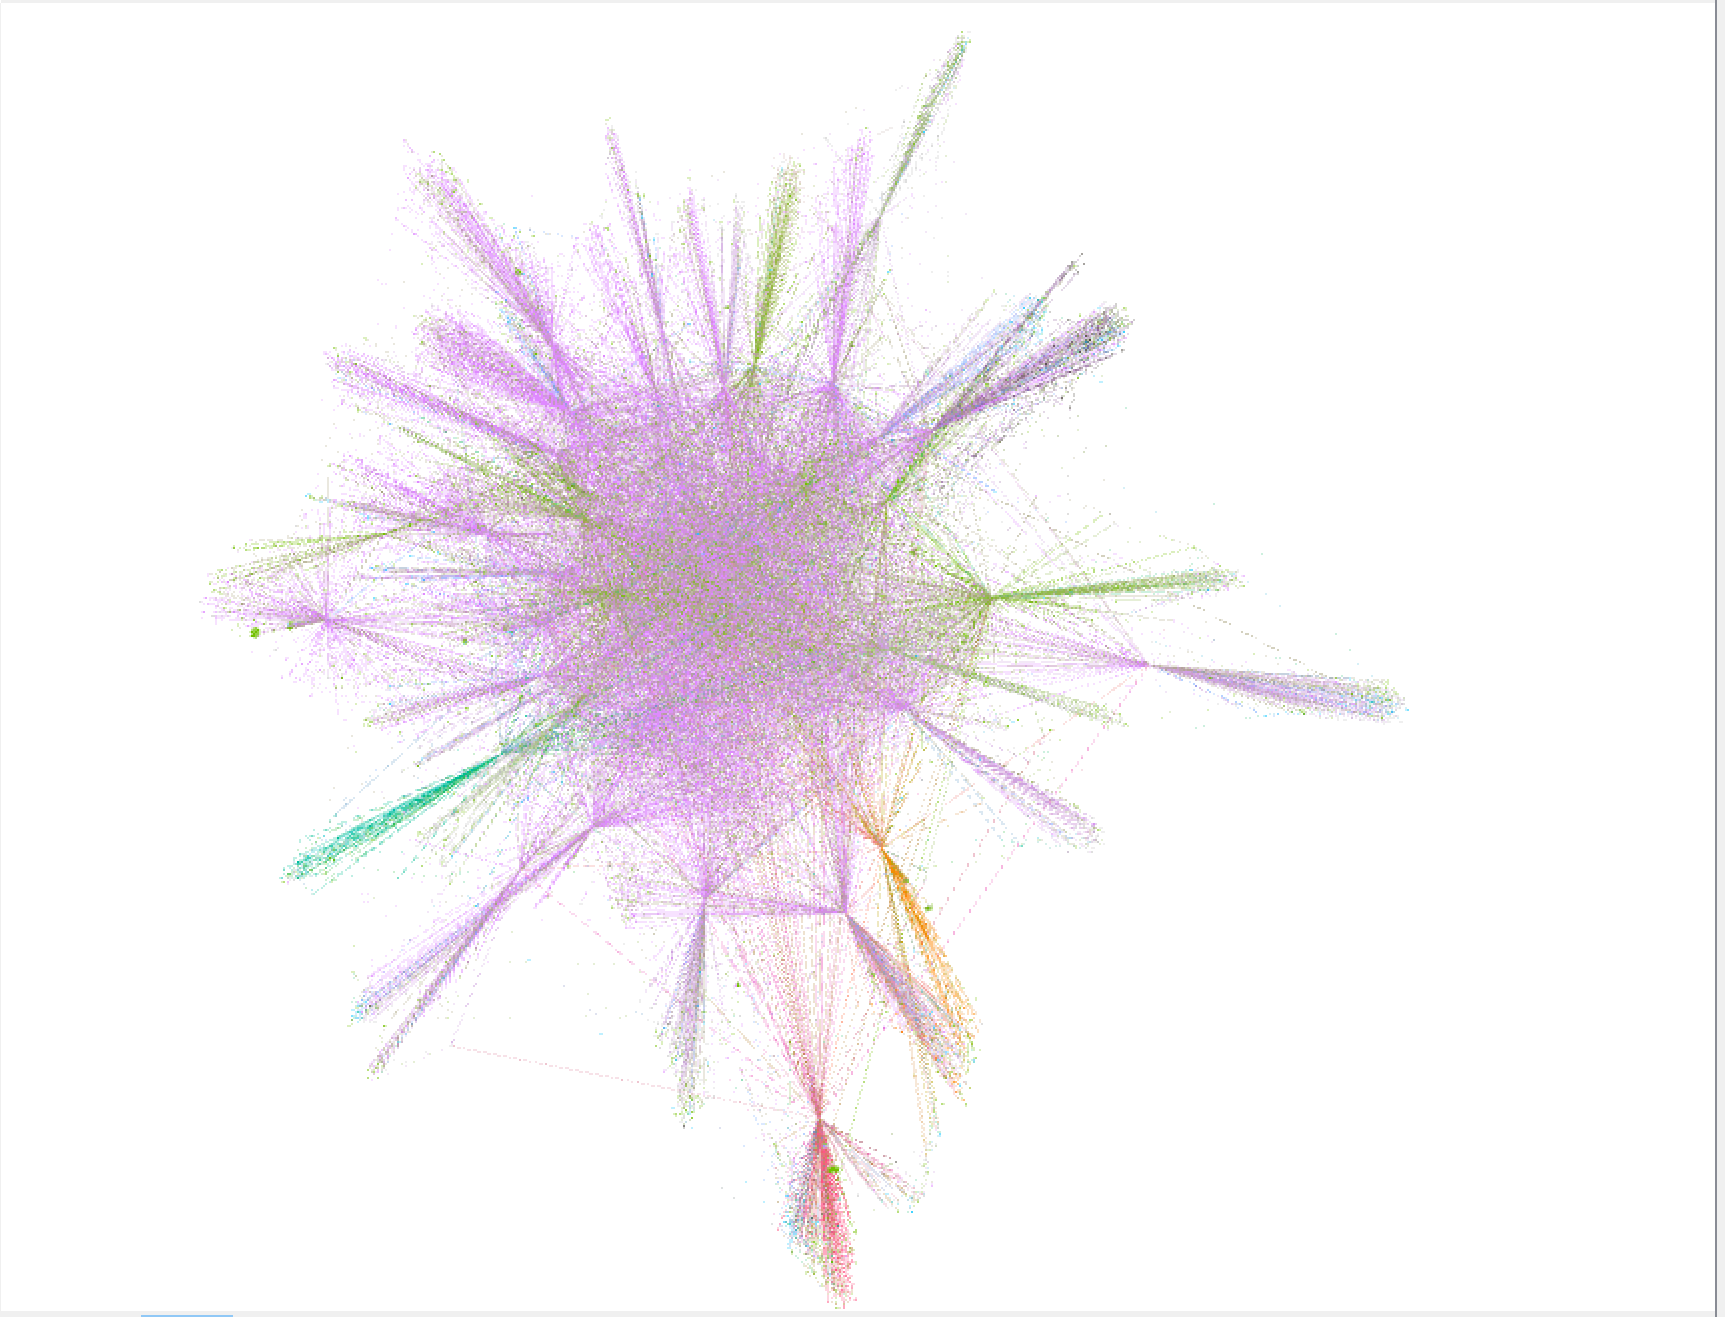

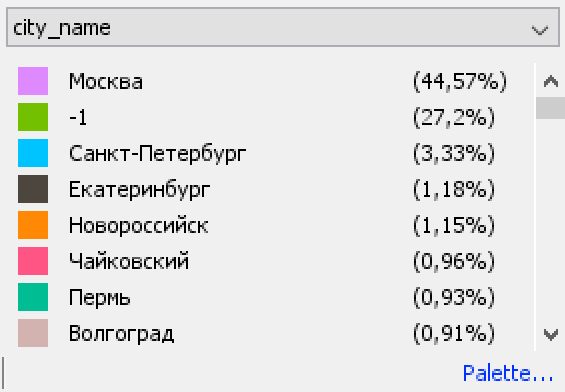

Прорисовка графа в зависимости от степени вершины

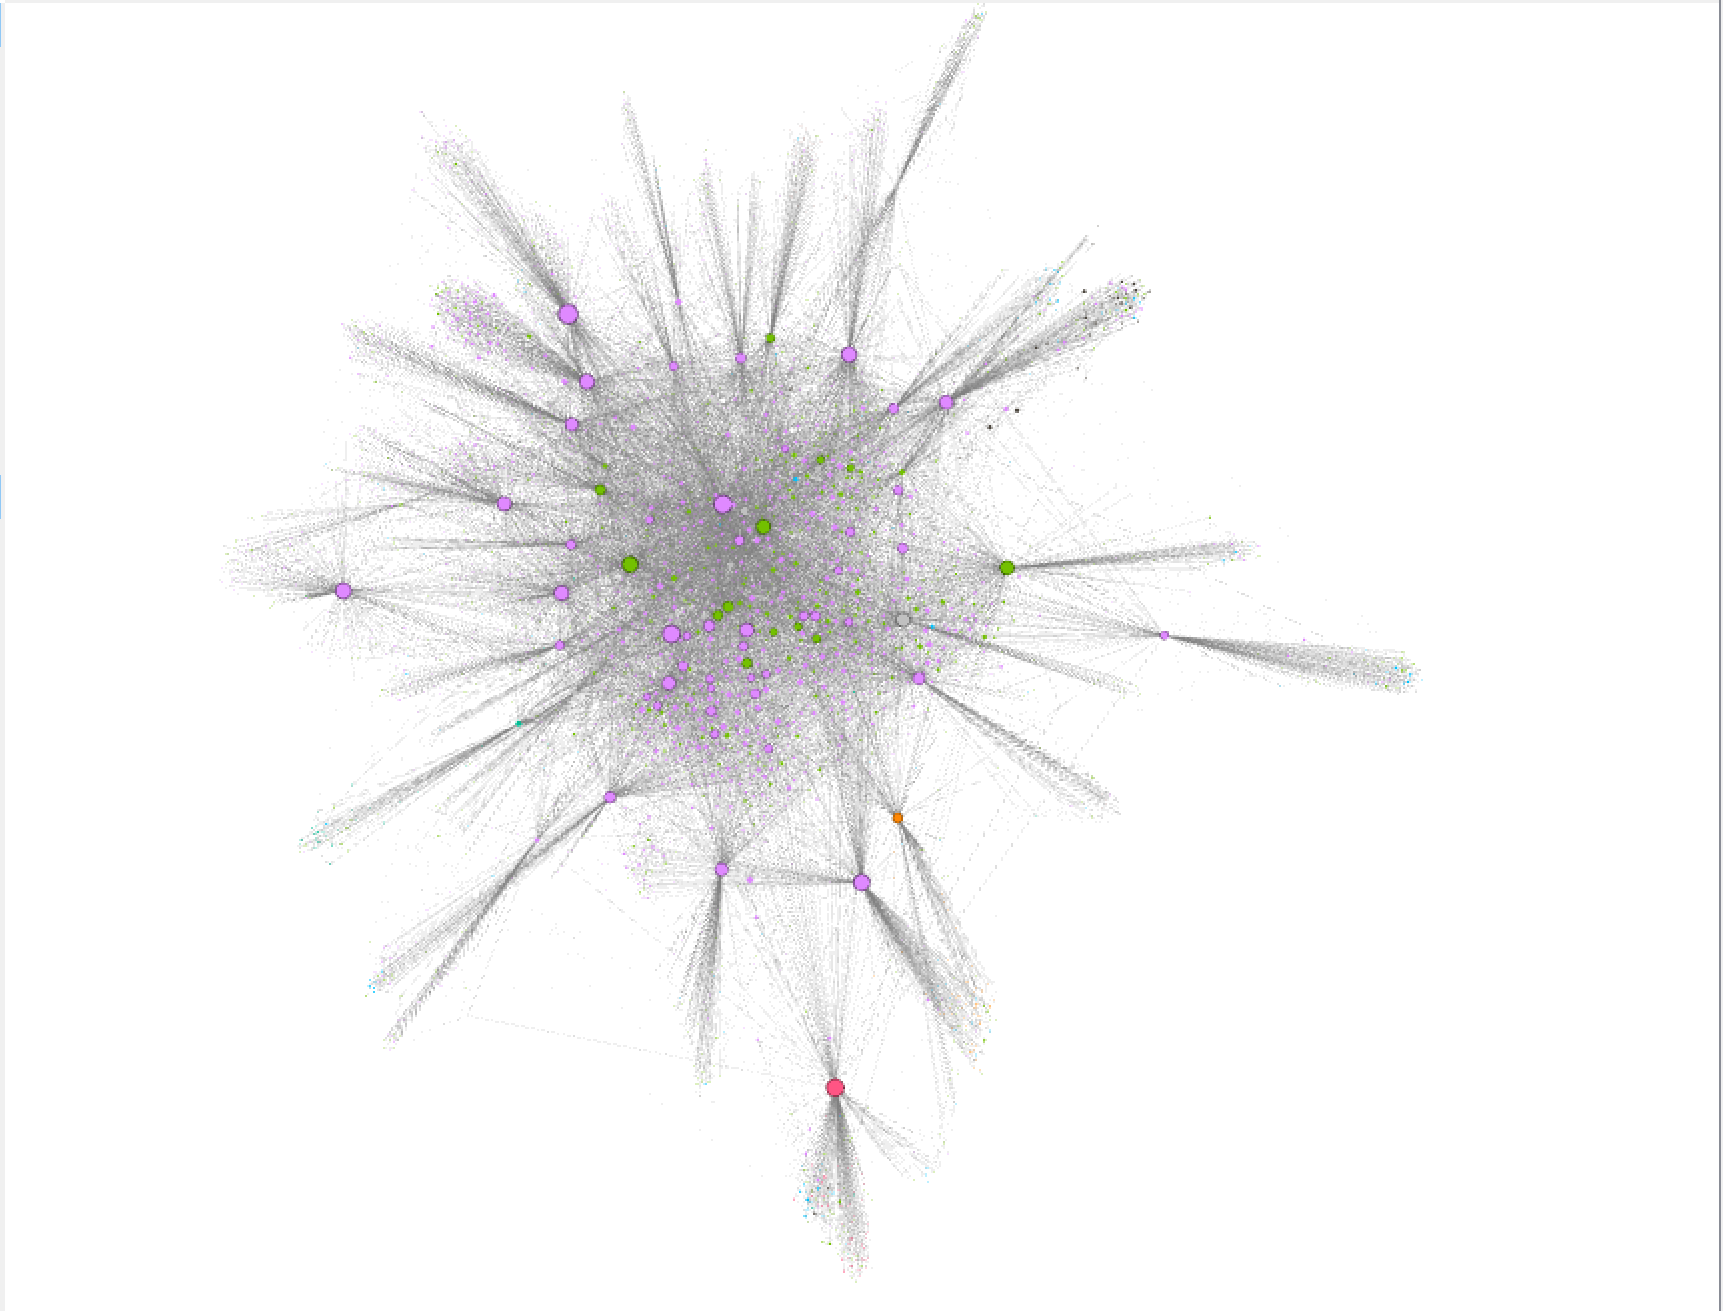

# Центральности вершин

In [304]:
def keywithmaxval(d): 
     v=list(d.values())
     k=list(d.keys())
     return k[v.index(max(v))]
def key_min(d): 
     v=list(d.values())
     k=list(d.keys())
     return k[v.index(min(v))]

In [305]:
degr_cent = nx.centrality.degree_centrality(g)
closeness_nodes = nx.centrality.closeness_centrality(g)
betw_nodes = nx.betweenness_centrality(g) 

In [306]:
print('Максимальные значения')
print('degree: ', keywithmaxval(degr_cent))
m1=keywithmaxval(degr_cent)
print(degr_cent[m1])
print('closeness centrality: ', keywithmaxval(closeness_nodes))
m2=keywithmaxval(closeness_nodes)
print(closeness_nodes[m2])
print('betweenes centrality: ',keywithmaxval(betw_nodes))
m3=keywithmaxval(betw_nodes)
print(betw_nodes[m3])

Максимальные значения
degree:  110661067
0.05876851130163679
closeness centrality:  90824519
0.45122470604860515
betweenes centrality:  82605916
0.05315332765941459


In [307]:
g1=g.copy()
numnod=g.number_of_nodes()
part=int(numnod/3)
for key in degr_cent:
    g1.nodes[key]['deg_cent']='others'
for i in range(0,part):
    mm=key_min(degr_cent)
    degr_cent.pop(mm,-1)
for key in degr_cent:
    g1.nodes[key]['deg_cent']='top 66%'
for i in range(0,part):
    mm=key_min(degr_cent)
    degr_cent.pop(mm,-1)
for key in degr_cent:
    g1.nodes[key]['deg_cent']='top 33%'
g1.nodes[m1]['deg_cent']='best'

In [308]:
for key in closeness_nodes:
    g1.nodes[key]['closeness']='others'
for i in range(0,part):
    mm=key_min(closeness_nodes)
    closeness_nodes.pop(mm,-1)
for key in closeness_nodes:
    g1.nodes[key]['closeness']='top 66%'
for i in range(0,part):
    mm=key_min(closeness_nodes)
    closeness_nodes.pop(mm,-1)
for key in closeness_nodes:
    g1.nodes[key]['closeness']='top 33%'
g1.nodes[m2]['closeness']='best'

In [309]:
for key in betw_nodes:
    g1.nodes[key]['betw']='others'
for i in range(0,part):
    mm=key_min(betw_nodes)
    betw_nodes.pop(mm,-1)
for key in betw_nodes:
    g1.nodes[key]['betw']='top 66%'
for i in range(0,part):
    mm=key_min(betw_nodes)
    betw_nodes.pop(mm,-1)
for key in betw_nodes:
    g1.nodes[key]['betw']='top 33%'
g1.nodes[m3]['betw']='best'

In [310]:
nx.write_graphml(g1, 'visual.graphml')

Лучшая вершина с точки зрения degree centrality: синяя 
Лучшая вершина с точки зрения closeness centrality: красная
Лучшая вершина с точки зрения betweenness centrality: зеленая

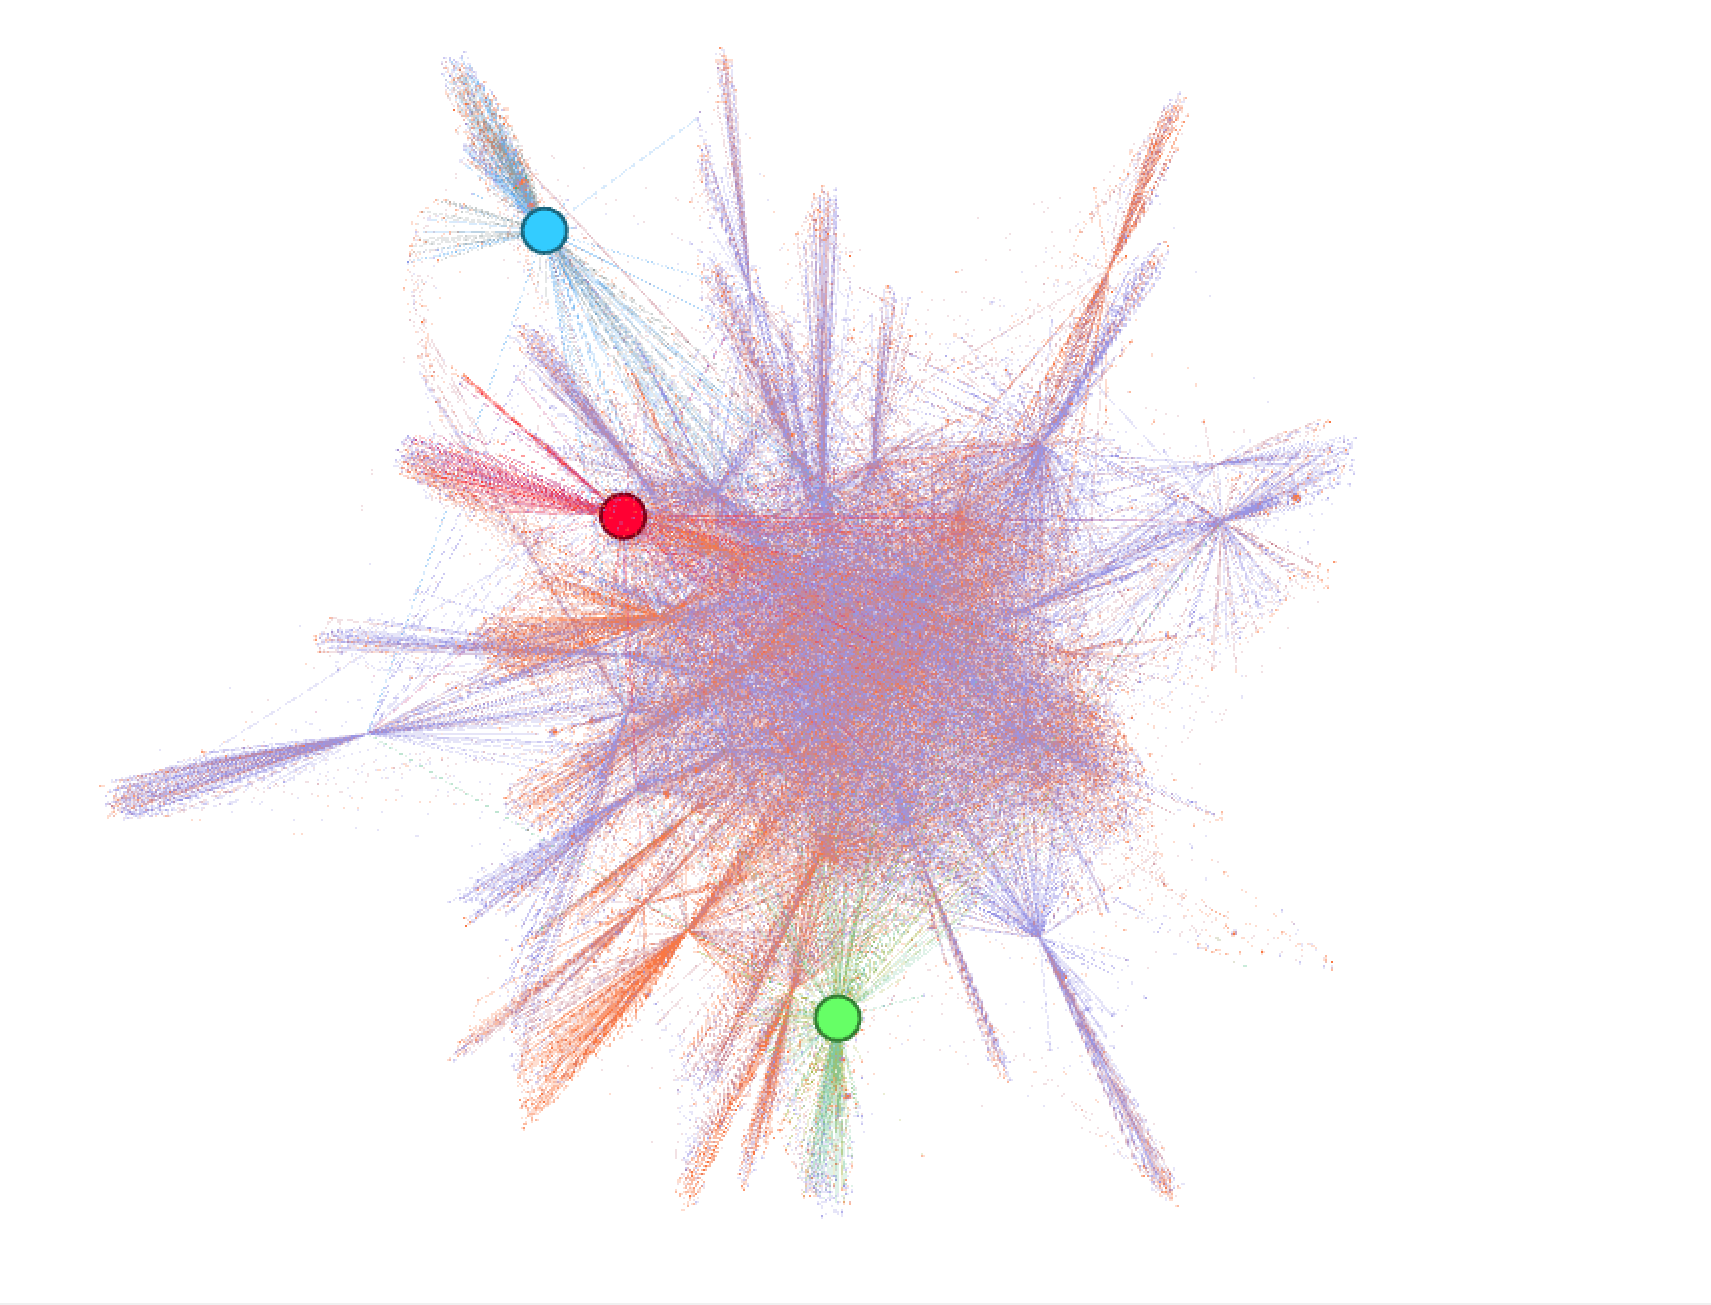

Ранжирование вершин по degree centrality:

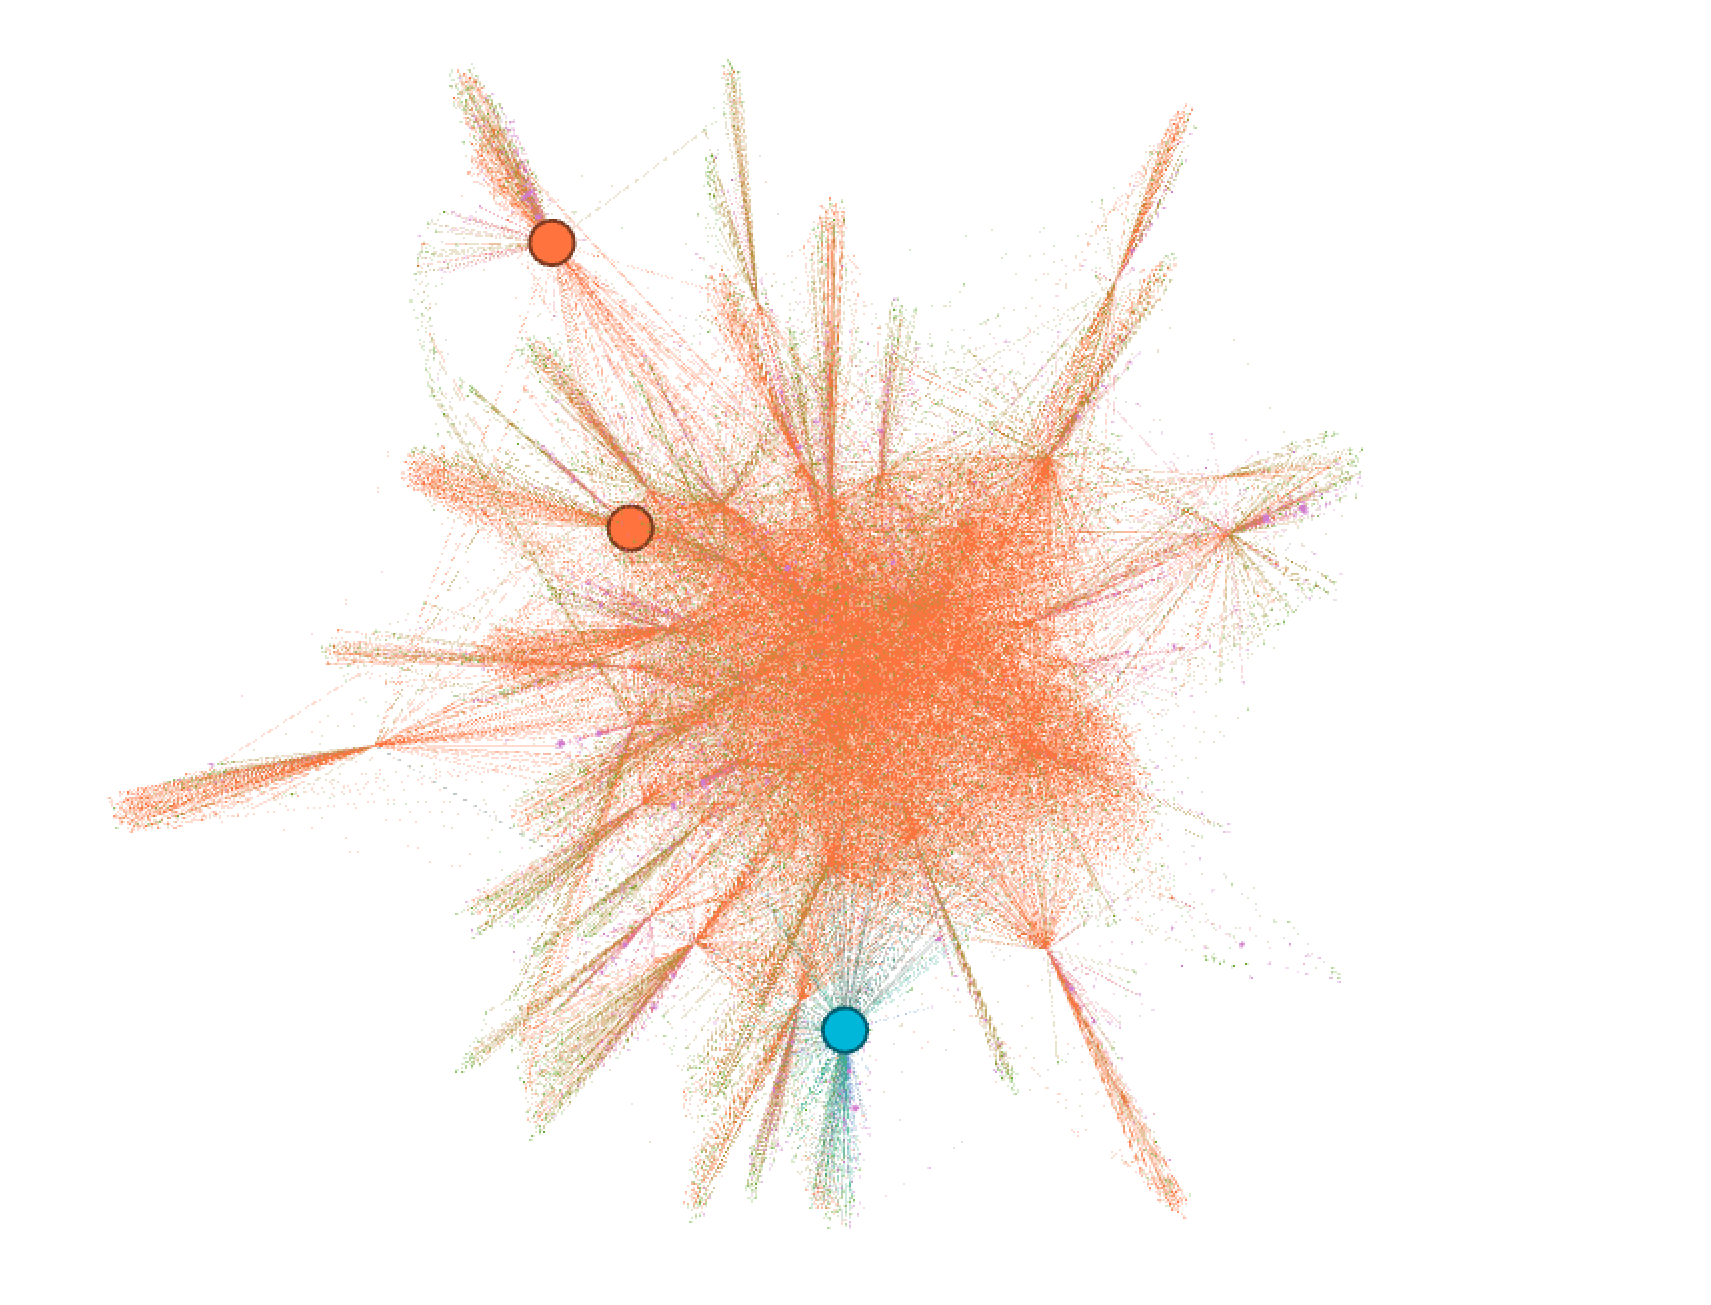

Легенда degree centrality:

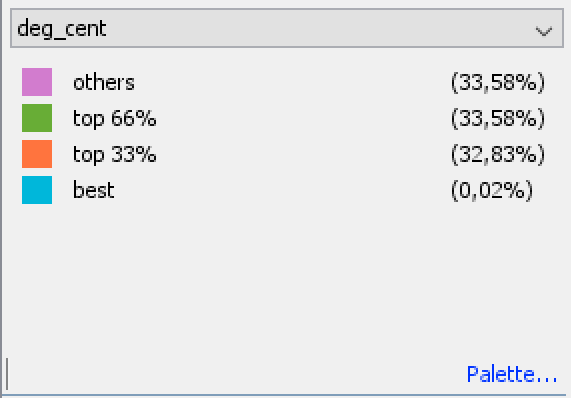

Ранжирование вершин по closeness centrality:

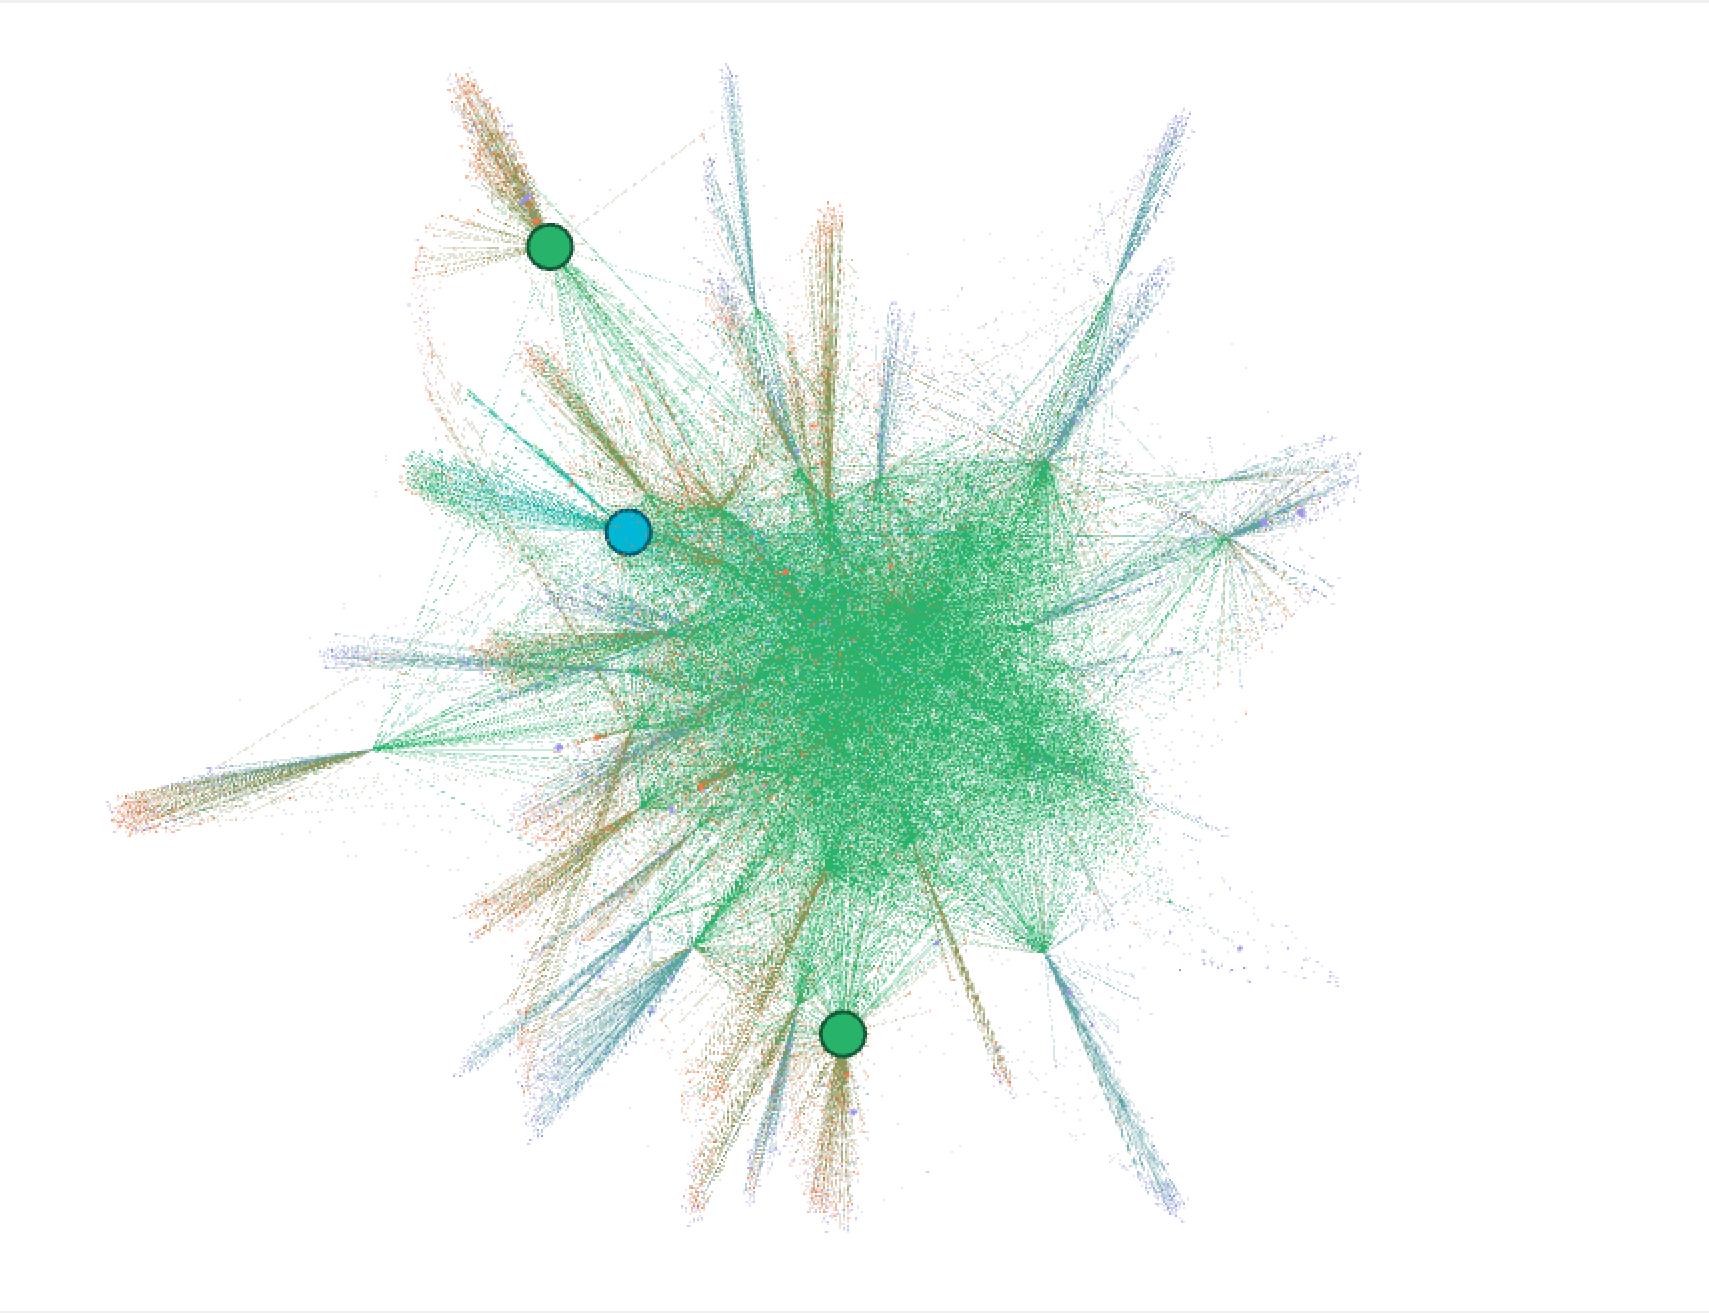

Легенда closeness centrality:

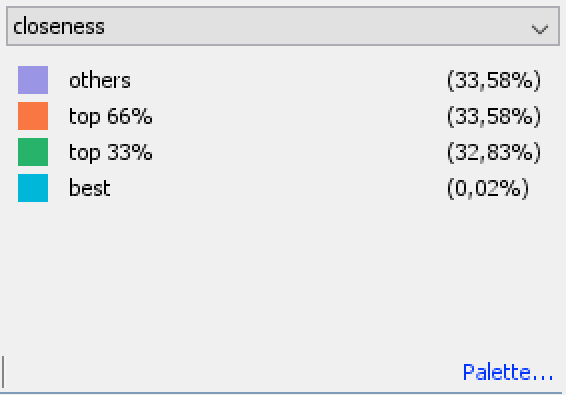

Ранжирование вершин по betweenes centrality:

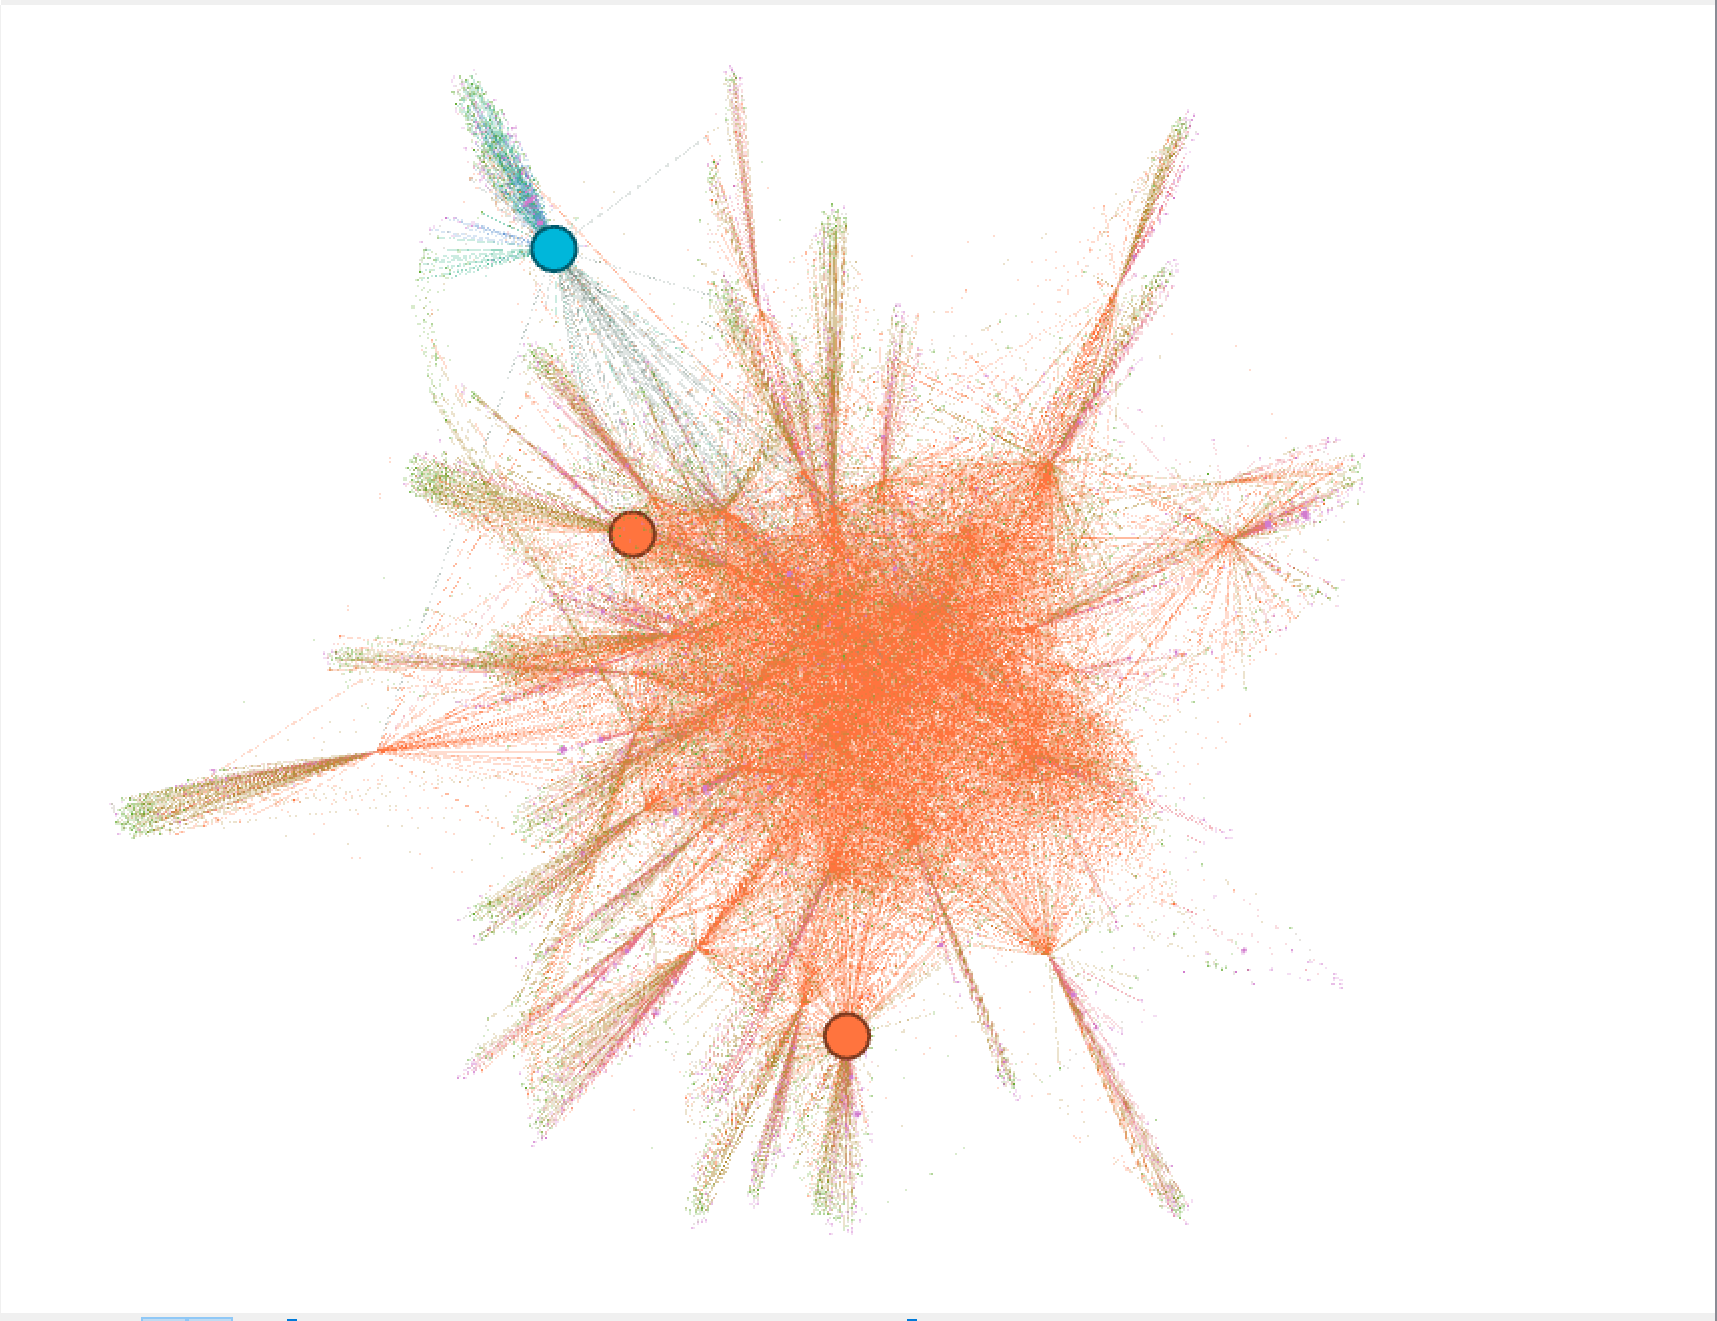

Легенда betweenes centrality:

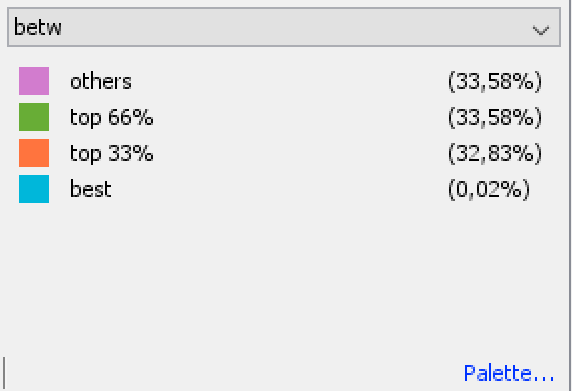

# Сообщества в сообществе

# jaccard

In [311]:
from scipy.sparse import coo_matrix
from sklearn.cluster import SpectralClustering
import matplotlib.pyplot as plt

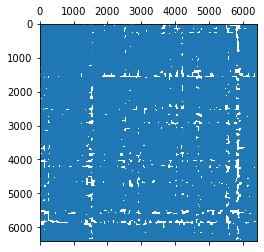

In [312]:
p=g.copy()
p1 = nx.Graph()
pp = nx.disjoint_union(p1, p)
A = nx.adj_matrix(pp)
plt.spy(A, markersize=2)

In [313]:
jac = nx.jaccard_coefficient(pp)
jac = np.array(list(jac))
size=pp.number_of_nodes()

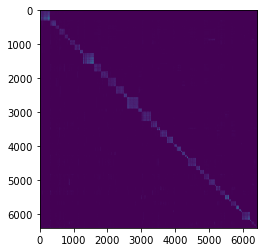

In [314]:
from scipy.sparse import coo_matrix
D = coo_matrix((jac[:,2], (jac[:,0], jac[:,1])), shape=(size,size))
D = D+D.T
plt.imshow(D.toarray())

In [315]:
model = SpectralClustering(n_clusters=11, affinity='rbf')
model.fit(D)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\_spectral.py:484: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn("The spectral clustering API has changed. ``fit``"


SpectralClustering(n_clusters=11)

In [316]:
labels = model.labels_
label1=[]
for j in labels:
    label1.append(j)
for i in range(0,size):
    pp.nodes[i]['jacar']=label1[i]

In [317]:
from networkx.algorithms.community.quality import modularity
def marks(labels):
   a=[]
   for i in labels:
       if i not in a:
          a.append(i)
   return a
def make_commun(labels):
    res=dict()
    helper=marks(labels)
    for mark in helper:
        res[mark]=set()
    hh=0
    for i in labels:
        res[i].add(hh)
        hh=hh+1
    result=[]
    for key in res:
        result.append(res[key])
    return result

In [319]:
import warnings
warnings.filterwarnings('ignore')
best=[]
for i in tqdm_notebook(range(2,16)):
    model = SpectralClustering(n_clusters=i, affinity='precomputed')
    model.fit(D)
    labels = model.labels_
    beta=make_commun(labels)
    b1=modularity(pp,beta)
    best.append(b1)

In [320]:
max_best=max(best)
best_num=best.index(max_best)+2
print(max_best)
print(best_num)

0.20272954246158847
15


In [321]:
model = SpectralClustering(n_clusters=best_num, affinity='precomputed')
model.fit(D)
labels = model.labels_
label1=[]
for j in labels:
    label1.append(j)
for i in range(0,size):
    pp.nodes[i]['jacar']=label1[i]

In [322]:
nx.write_graphml(pp, 'jacar.graphml')

Результат работы алгоритма на основе похожести вершин (jaccard), 15 кластеров:

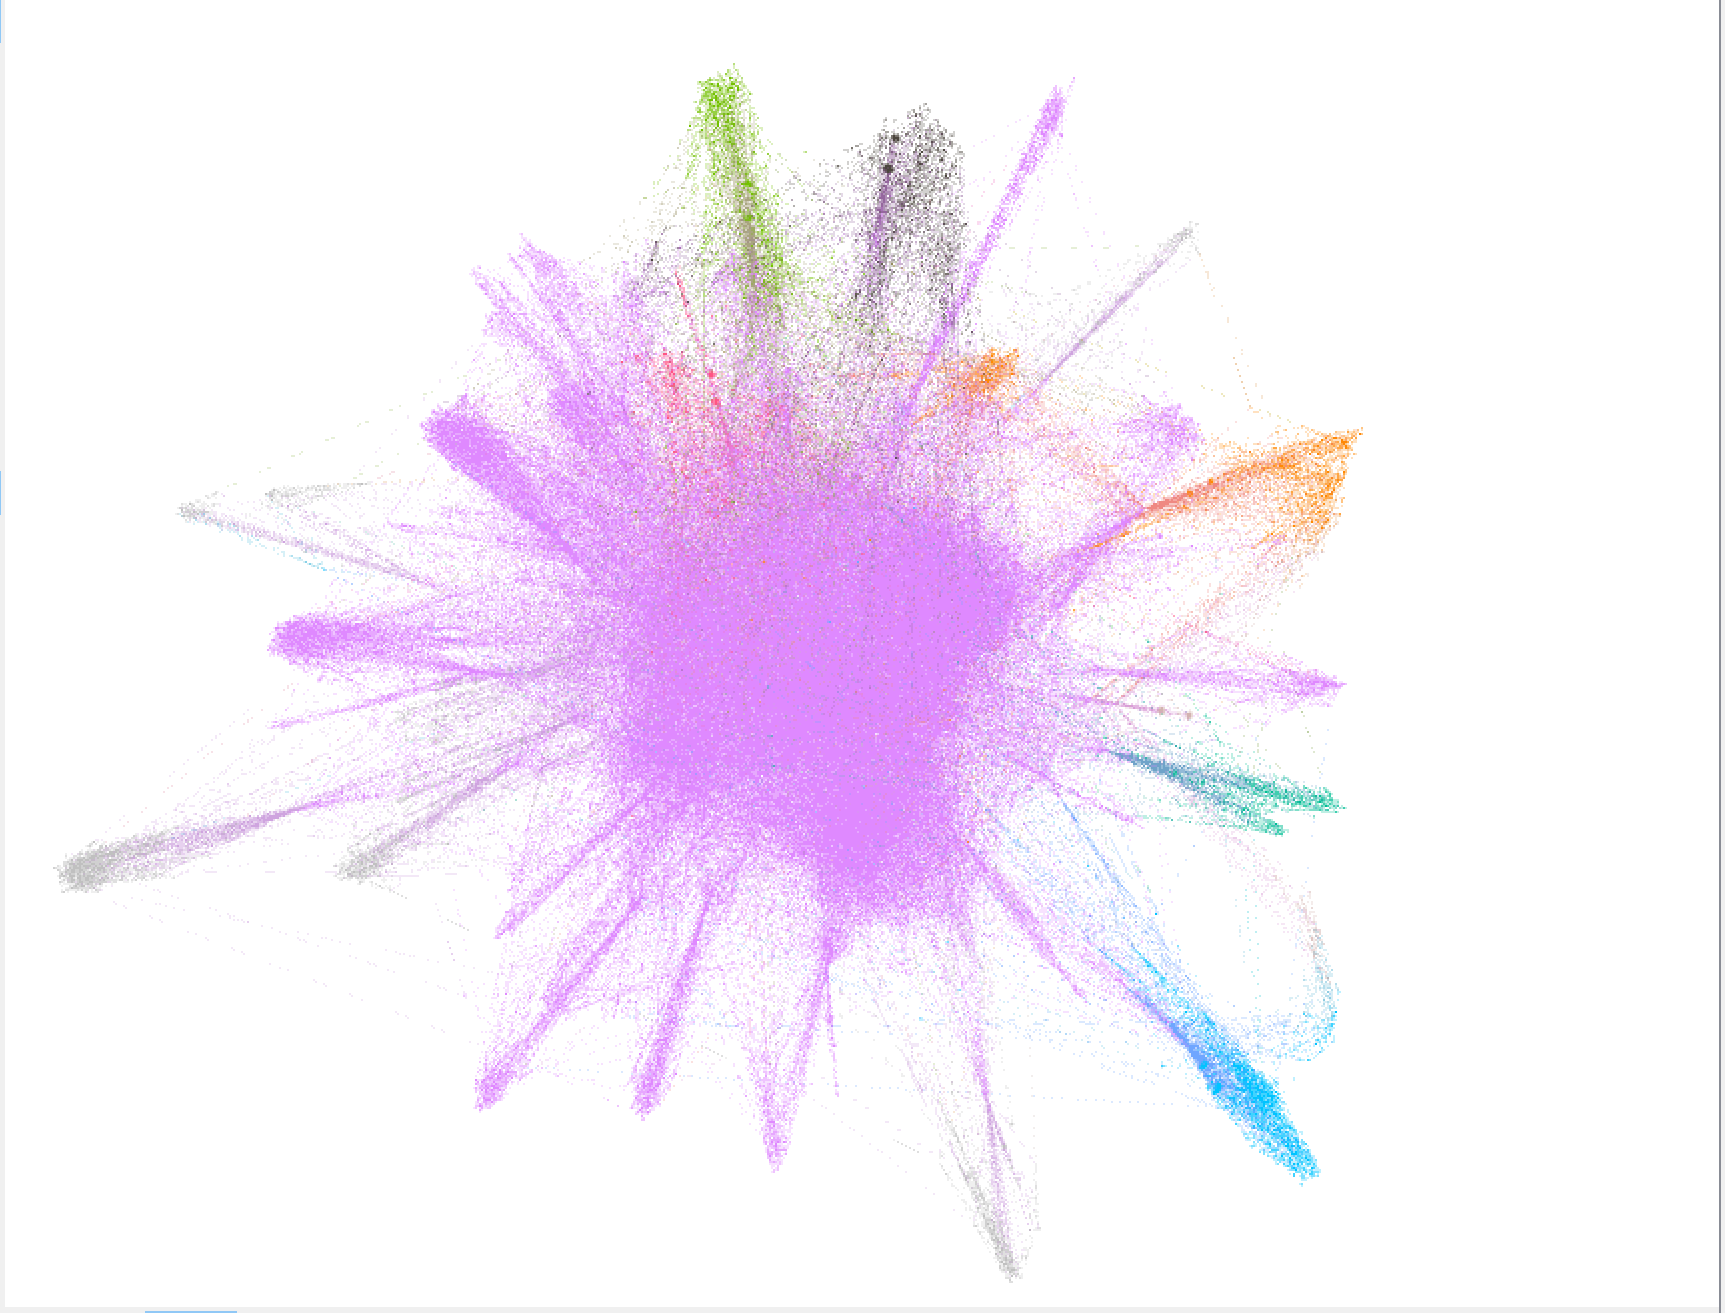

# Label propagation

In [323]:
qq=g.copy()

In [324]:
def get_labeling_from_partition(partition):
    all_nodes = set()
    for cluster in partition:
        all_nodes |= cluster
    num_nodes = len(all_nodes)
    labeling = dict()
    for label, ids in enumerate(partition):
        ids = list(ids)
        for i in ids:
           labeling[i] = label    
    return labeling
def to_form(lp_labeling):
   a=[]
   for key in lp_labeling:
      if lp_labeling[key] not in a:
         a.append(lp_labeling[key])
   final=dict()
   for i in a:
      final[i]=set()
   for key in lp_labeling:
      final[lp_labeling[key]].add(key)
   resik=[]
   for key in final:
      resik.append(final[key])
   return resik

In [326]:
best=[]
for i in tqdm_notebook(range(0,51)):
    lp_partition = nx.community.asyn_lpa_communities(qq,seed=i)
    lp_partition = list(lp_partition)
    lp_labeling = get_labeling_from_partition(lp_partition)
    res=to_form(lp_labeling)
    b1=modularity(qq,res)
    best.append(b1)  

In [327]:
max_best=max(best)
best_num=best.index(max_best)
print(max_best)
print(best_num) 

0.6137020038388027
50


In [328]:
lp_partition = nx.community.asyn_lpa_communities(qq,seed=best_num)
lp_partition = list(lp_partition)
lp_labeling = get_labeling_from_partition(lp_partition)
for key in lp_labeling:
    qq.nodes[key]['propagation']=lp_labeling[key]

In [329]:
nx.write_graphml(qq, 'labeprop.graphml')

Результат работы label propagation

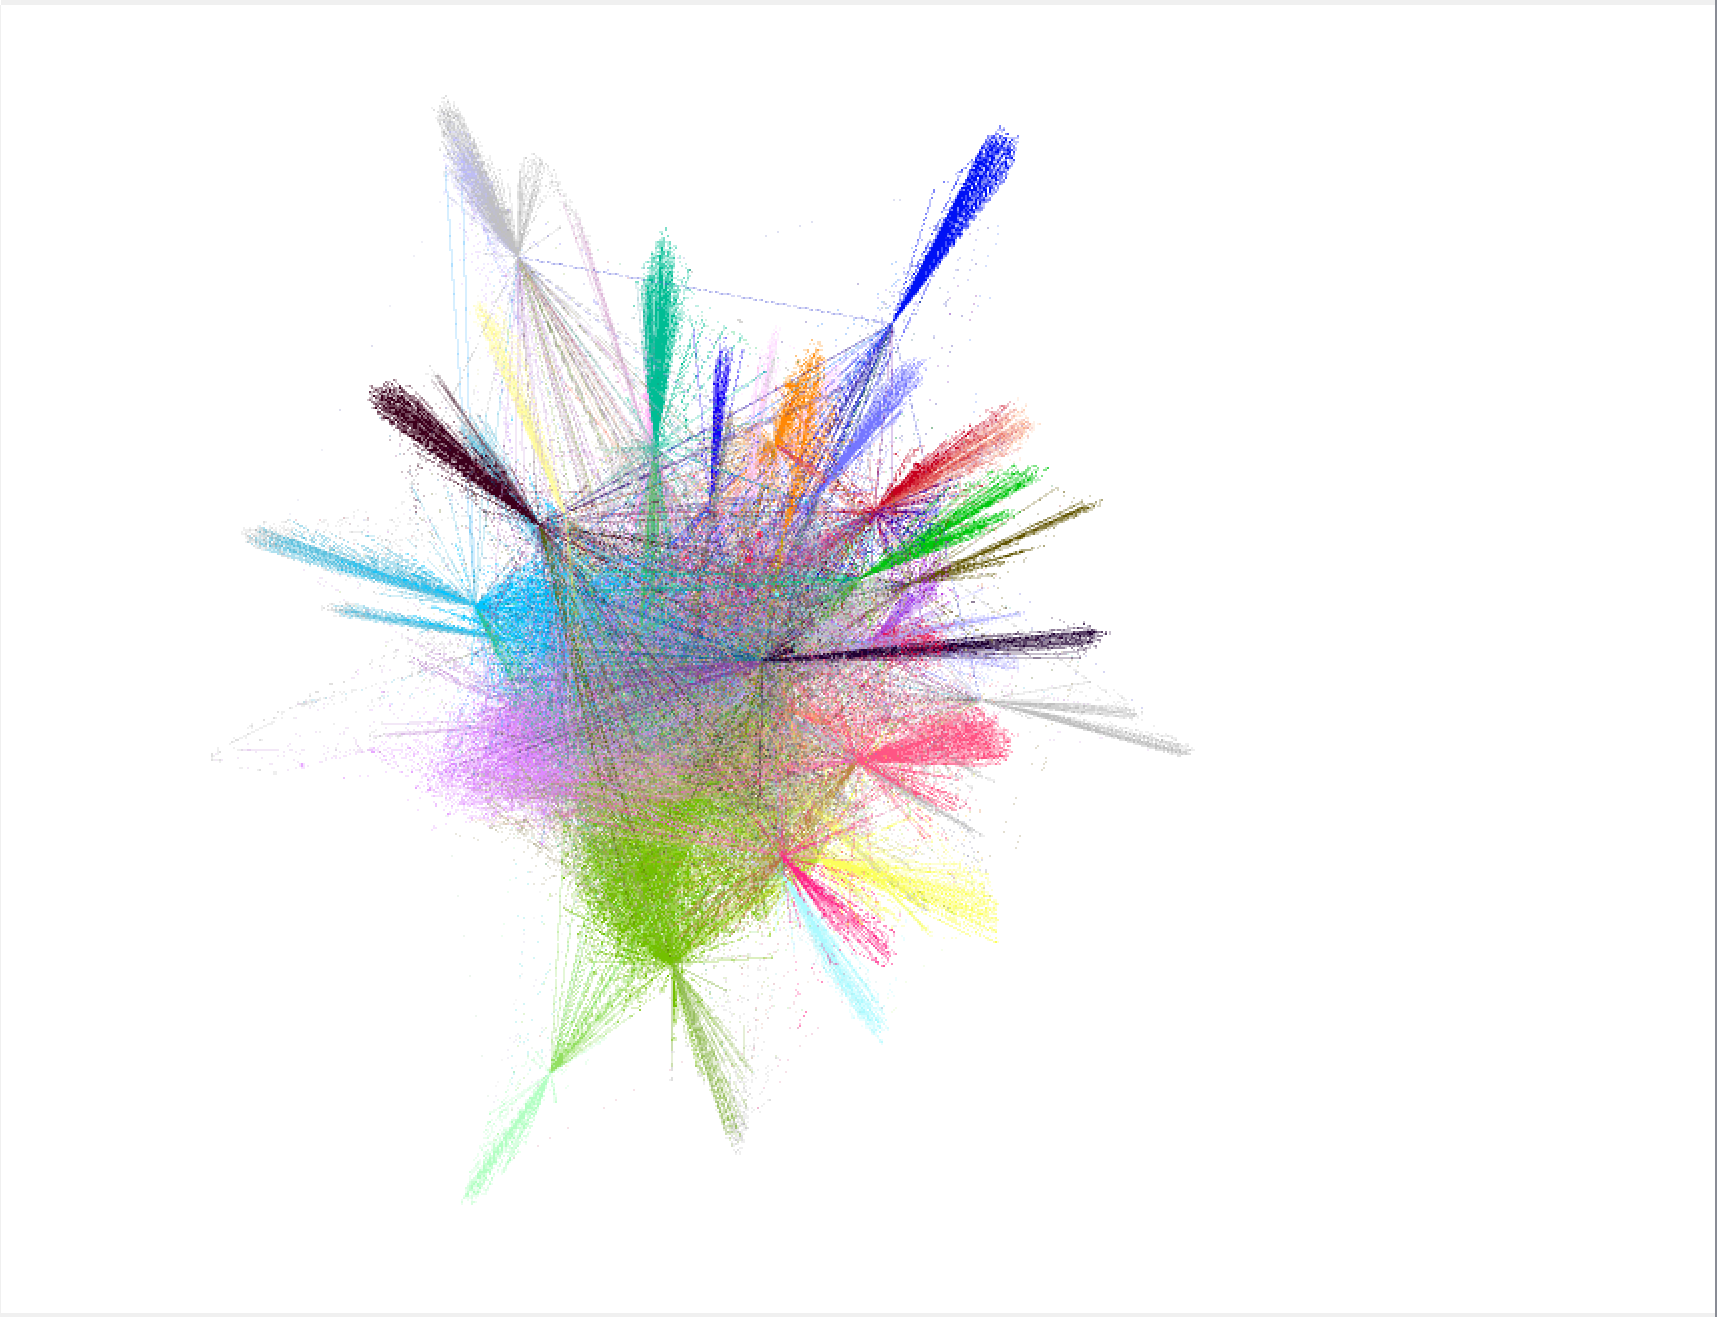

Из извлеченных признаков наиболее информативным является название города. Если сопоставить полученные разбиения на сообщества с разбиениями по городам, то можно заметить, что в основном люди из разных сообществ прибыли в Москву для обучения в МГУ из разных городов. До приезда у них уже были друзья и семья в их городах, которые вошли в их сообщества. Кроме того, даже люди, приехавшие в Москву из одного города, могли учиться в разных школах. Москвичи также могли обучаться в разных школах.
С точки зрения такого признака, разбиение с помощью label propogation дает гораздо лучший результат. Мы сохраняем сообщества людей из Перми, Екатеринбурга, Новороссийска, Чайковского и др. Кроме того, вершина наибольшей степени из разных сообществ обучались в разных школах.
Результа работы алгоритма на основе jaccard дает гораздо худший результат, но в то же время хорошо показывает большое сообщество москвичей, которое утрачивается при работе label propagation.

Сообщества по городам с легендой:

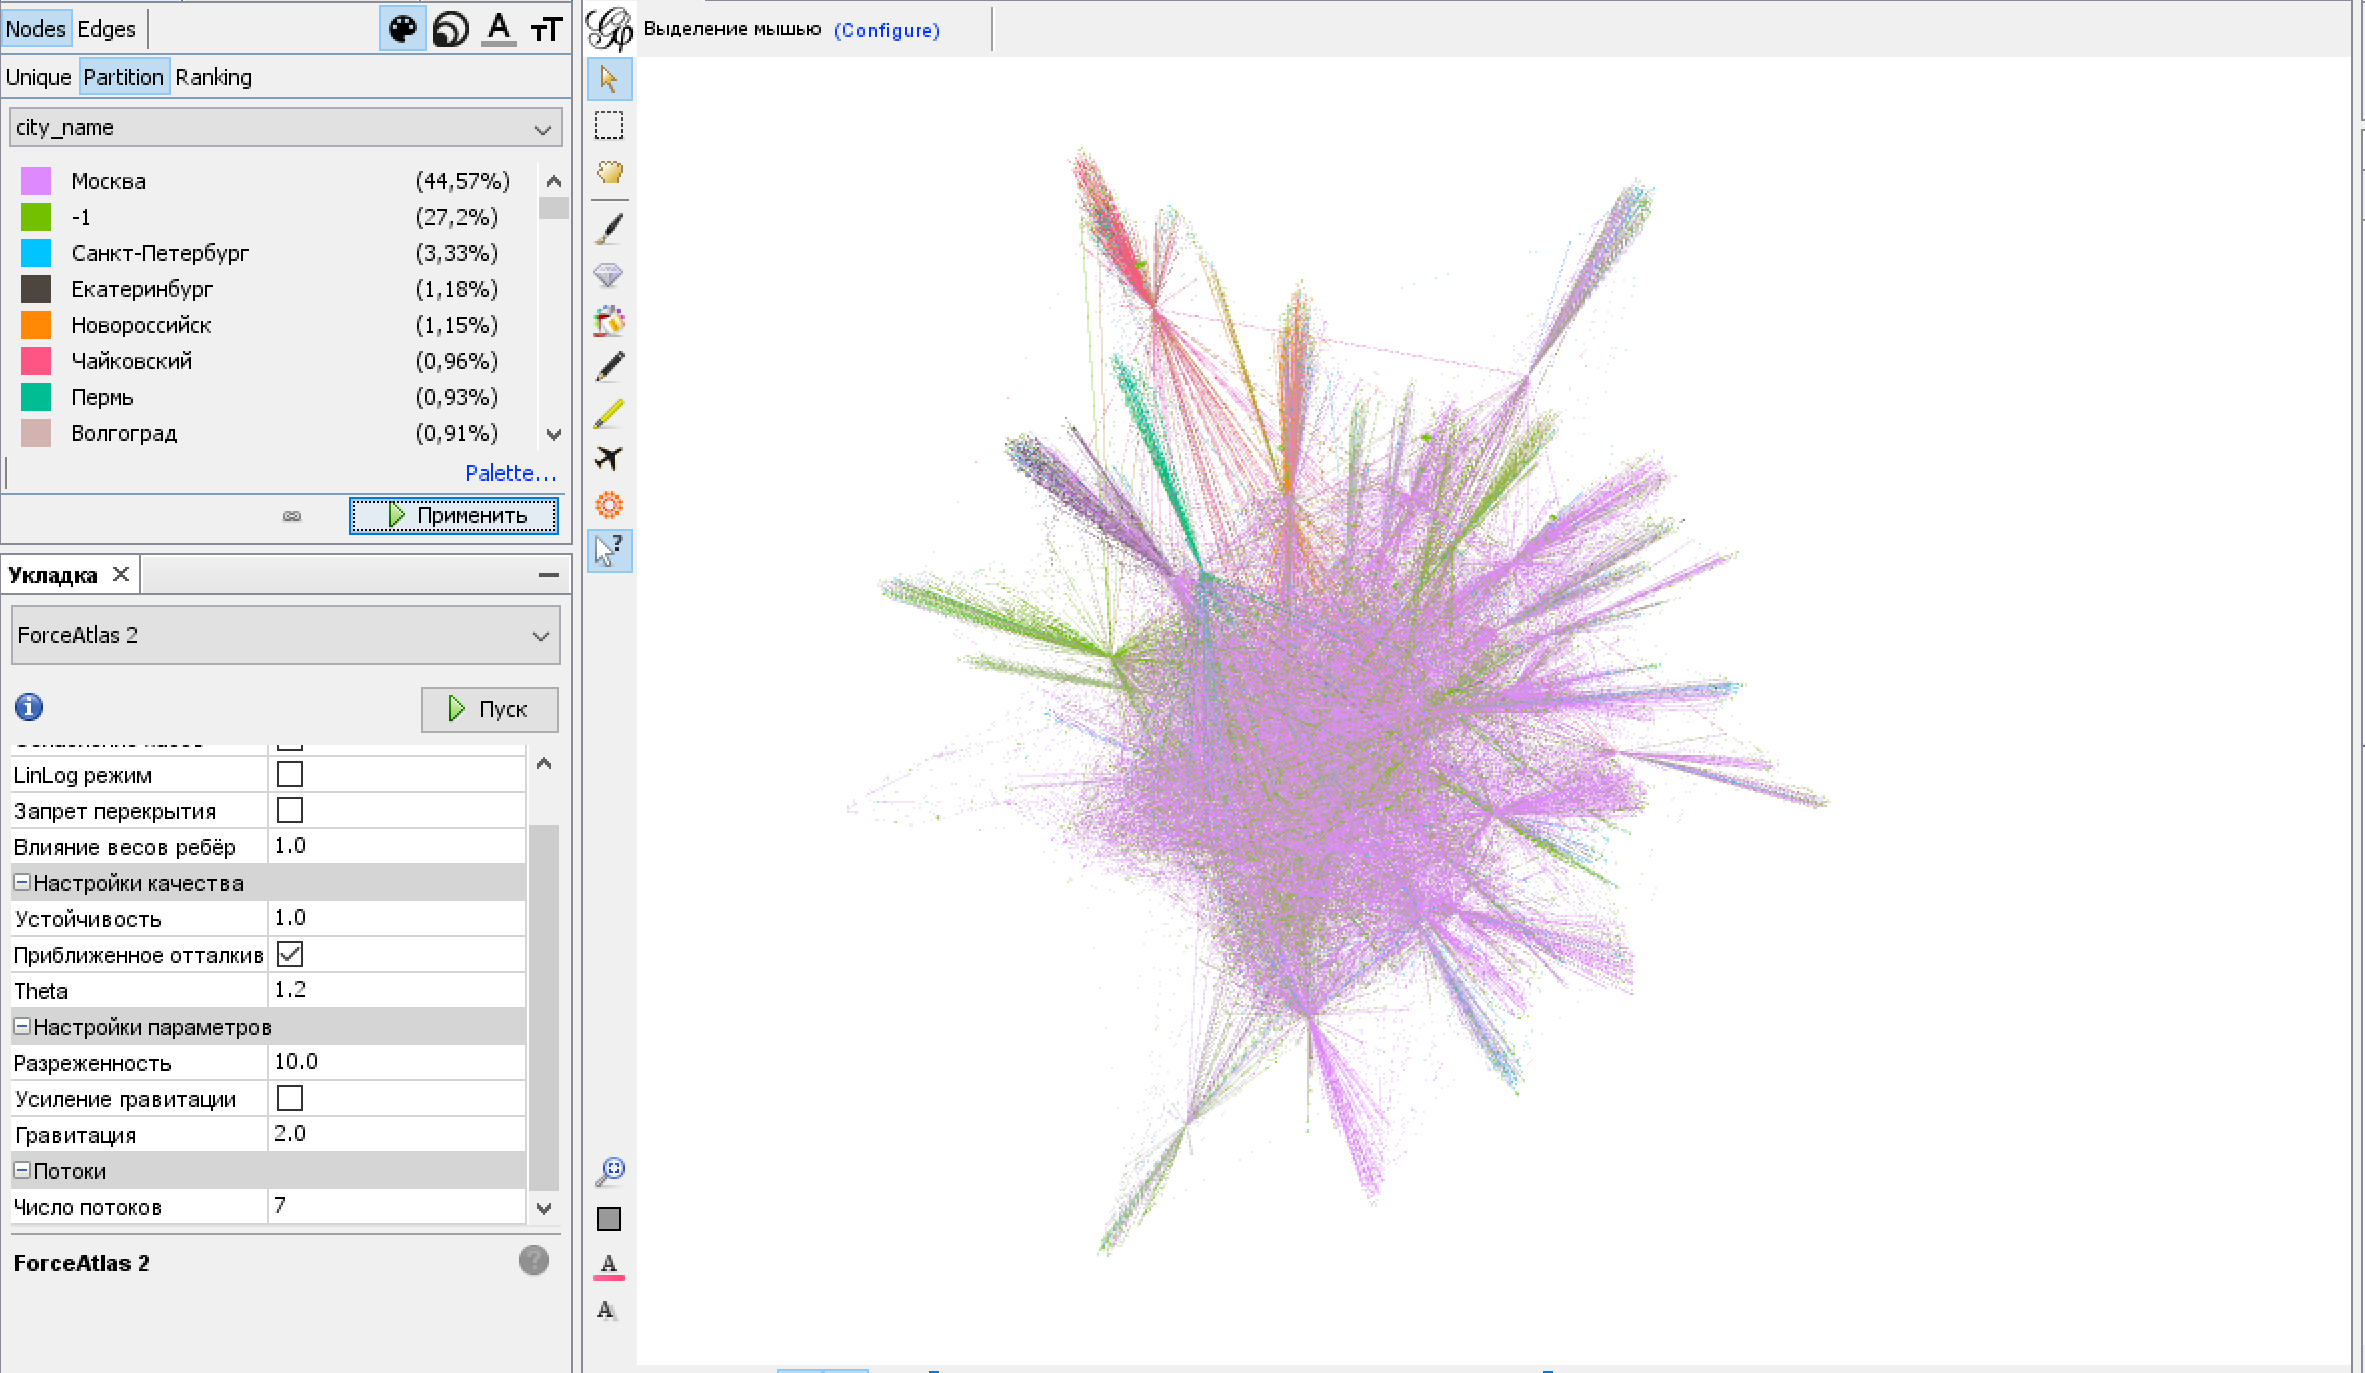